## Pymaceuticals Inc.

    Pymaceuticals Inc provided some data getting from study. In this study, 249 mice identified with SCC tumor growth were treated through a variety of drug regimens. Over the course of 45 days, tumor development was observed and measured. The purpose of this study was to compare the performance of Pymaceuticals' drug of interest, Capomulin, versus the other treatment regimens.

In [1]:
# Dependencies
import pandas as pd
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up the path to files with data
mouse_data_file = 'Resources/Mouse_metadata.csv'
study_result_data_file = 'Resources/Study_results.csv'

In [3]:
# Read mouse_metadata.csv file to DataFrame
mouse_original_df = pd.read_csv(mouse_data_file)
mouse_original_df.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [4]:
# Read study_result.csv to DataFrame
study_res_original_df = pd.read_csv(study_result_data_file)
study_res_original_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [5]:
# Merge both df together. Inner join because we need anly mouse that included in study_result file
summary_df = study_res_original_df.merge(mouse_original_df, on='Mouse ID', how='inner')
summary_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [6]:
# Find duplicated mouses 
duplicated_row_df = summary_df[summary_df.duplicated(['Mouse ID', 'Timepoint'])]
duplicated_row_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
861,g989,0,45.000000,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [8]:
# Get mouse id from duplicated df
mouse_id = duplicated_row_df['Mouse ID'].unique()
mouse_id = mouse_id[0]

# delete all rows with given mouse id
summary_df.drop(summary_df[summary_df['Mouse ID'] == mouse_id].index, inplace=True)
len(summary_df['Mouse ID'].unique())

248

#### Summary Statistics

Below will be generated a summary statistics table consisting of the **mean, median, variance, standard deviation, and SEM** of the tumor volume for each drug regimen.

In [9]:
# groupby by drug regime
regime = summary_df.groupby('Drug Regimen')

# generate mean 
mean_tumor_volume = regime['Tumor Volume (mm3)'].mean()

# generate median
median_tumor_volume = regime['Tumor Volume (mm3)'].median()

drugs = summary_df['Drug Regimen'].unique()
drugs

# variable to store variance, standart deviation and sem for each drug
variance = []
st_dv = []
std_err = []

for drug in drugs:
    certain_drug = summary_df[summary_df['Drug Regimen'] == drug]
    variance.append(scs.tvar(certain_drug['Tumor Volume (mm3)']))
    st_dv.append(scs.tstd(certain_drug['Tumor Volume (mm3)']))
    std_err.append(scs.sem(certain_drug['Tumor Volume (mm3)']))

    
# Create a summary df
base_statistics_df = pd.DataFrame({"Mean Tumor Volume": mean_tumor_volume
                                  , "Median Tumor Volume": median_tumor_volume
                                  , "Tumor Volume Variance": variance
                                  , 'Tumor Volum Std. Dev.': st_dv
                                  , "Tumor Volum Std. Err": std_err})
base_statistics_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volum Std. Dev.,Tumor Volum Std. Err
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,68.553577,8.279709,0.603860
Infubinol,52.884795,51.820584,66.173479,8.134708,0.596466
Ketapril,55.235638,53.698743,43.128684,6.567243,0.492236
Naftisol,54.331565,52.509285,59.450562,7.710419,0.573111
Placebo,54.033581,52.288934,23.486704,4.846308,0.320955
Propriva,52.320930,50.446266,48.533355,6.966589,0.516398
Ramicane,40.216745,40.673236,43.852013,6.622085,0.544332
Stelasyn,54.233149,52.431737,61.168083,7.821003,0.581331


### Bar plot 'mouse per treatment regimen'
**Bar plot using DataFrame.plot()**

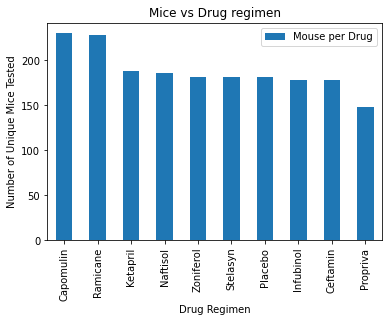

In [10]:
# list to store a count of mouse per treatment regimen
mouse_per_drugs = []

# count how many mouse were studied per treatment regimen
for drug in drugs:
    mouse_per_drugs.append(summary_df[summary_df['Drug Regimen'] == drug]['Mouse ID'].count())

# combine data to DataFrame and sort it    
mouse_vs_drugs_df = pd.DataFrame({'Drugs': drugs, 'Mouse per Drug': mouse_per_drugs}, index=drugs)
mouse_vs_drugs_df= mouse_vs_drugs_df.sort_values(by='Mouse per Drug', ascending=False)

# Generate a Bar plot
bar_plot = mouse_vs_drugs_df.plot.bar()
bar_plot.set(xlabel='Drug Regimen', ylabel='Number of Unique Mice Tested', title='Mice vs Drug regimen')
plt.show()

**Bar plot using pyplot**

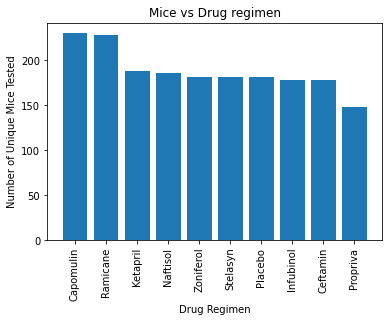

In [11]:
plt.bar(mouse_vs_drugs_df['Drugs'], mouse_vs_drugs_df['Mouse per Drug'])
plt.xticks(rotation=90, horizontalalignment="center")
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Unique Mice Tested')
plt.title('Mice vs Drug regimen')
plt.show()

### Pie Plot 'the distribution of female or male mice in the study'

**Pie plot using DataFrame.plot()**

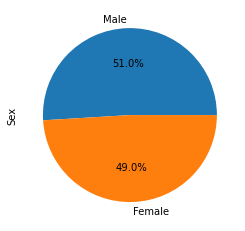

In [13]:
sex = summary_df['Sex'].value_counts()
pie_plot = sex.plot.pie(y="Sex", autopct='%1.1f%%', startangle=0)
plt.show()

**Pie plot using pyplot**

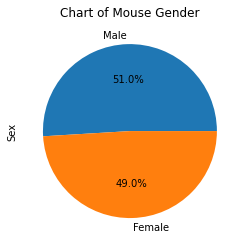

In [16]:
pie_labels = ['Male', 'Female']
plt.pie(sex, labels=['Male', 'Female'], autopct="%1.1f%%")
plt.title("Chart of Mouse Gender")
plt.ylabel('Sex')
plt.show()

### Quartiles, Outliers and Boxplots

Below will be calculated:
* the final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin. 
* the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

In [18]:
# Create a df to calculate final tumor volume
final_tumor_volume_df = summary_df[['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Drug Regimen']]

In [20]:
# list of most promising treatment regimens
treatment_regimen = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# leave only data for 4 drug regimen
final_tumor_volume_df = final_tumor_volume_df.sort_values(['Mouse ID', 'Timepoint'])
final_tumor_volume_df = final_tumor_volume_df[final_tumor_volume_df['Drug Regimen'].isin(treatment_regimen)]


**The final tumor volume of each mouse across four of the most promising treatment regimens**

In [23]:
## Group data by 'Mouse ID' to find max volume of tumor for the last timepoint

max_timepoint_df = final_tumor_volume_df.groupby('Mouse ID')['Timepoint'].max()
max_timepoint_df.reset_index()

max_tumor_volume_df = final_tumor_volume_df.merge(max_timepoint_df, on=['Mouse ID', 'Timepoint'])
max_tumor_volume_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Drug Regimen
0,a203,45,67.973419,Infubinol
1,a251,45,65.525743,Infubinol
2,a275,45,62.999356,Ceftamin
3,a411,45,38.407618,Ramicane
4,a444,45,43.047543,Ramicane


**The quartiles and IQR and quantitatively to determine potential outliers**

In [24]:

for drug in treatment_regimen:
    
    tumor_volume_by_drug = max_tumor_volume_df[max_tumor_volume_df['Drug Regimen'] == drug]    
    tumor_volume_by_drug = tumor_volume_by_drug['Tumor Volume (mm3)']
    
    quartiles = tumor_volume_by_drug.quantile([.25, .5, .75])
    q1 = quartiles[0.25]
    q3 = quartiles[0.75]
    
    iqr = q3 - q1
    iqr_1_5 = iqr * 1.5
    
    
    q1_bound = q1 - iqr_1_5
    q3_bound = q3 + iqr_1_5
    outliers = [q1_bound, q3_bound]
    
    potential_outliers = []
    for value in tumor_volume_by_drug:
        if value < q1_bound or value > q3_bound:
            potential_outliers.append(value)
    
    print(f"{drug}'s potential outliers: {potential_outliers}")
 
    

Capomulin's potential outliers: []
Ramicane's potential outliers: []
Infubinol's potential outliers: [36.321345799999996]
Ceftamin's potential outliers: []


**Generate a box and whisker plot of the final tumor volume for all four treatment regimens**

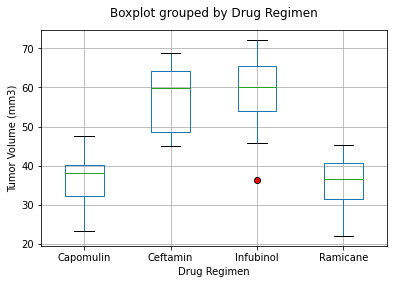

In [26]:
flierprops = dict(marker='o', markerfacecolor='red')
max_tumor_volume_df.boxplot(column=['Tumor Volume (mm3)'], by='Drug Regimen', flierprops=flierprops)
plt.title('')
plt.ylabel('Tumor Volume (mm3)')
plt.show()

**Select a mouse that was treated with Capomulin**

In [27]:
#Select a mouse that was treated with Capomulin and generate a line plot of tumor volume vs. time point for that mouse.

treated_mouses = summary_df[['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']]
treated_mouses = treated_mouses[treated_mouses['Drug Regimen'] == 'Capomulin']
treated_mice = treated_mouses[treated_mouses['Mouse ID'] == 'l509']

**Generate a line plot of tumor volume vs. time point for that mouse**

Text(0, 0.5, 'Tumor Volum (mm3)')

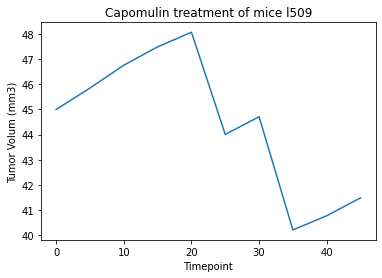

In [28]:
plt.plot(treated_mice['Timepoint'], treated_mice['Tumor Volume (mm3)'])
plt.title('Capomulin treatment of mice l509')
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volum (mm3)')

**Generate a scatter plot of mouse weight versus average tumor volume**

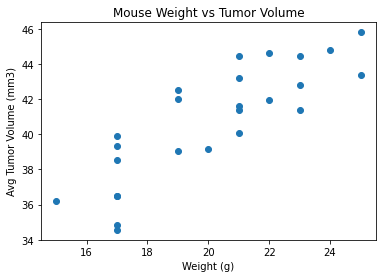

In [29]:
mouse_weight = summary_df[['Mouse ID', 'Weight (g)']]
treated_mouses = treated_mouses.merge(mouse_weight, on='Mouse ID')

avg_tumor_volume = treated_mouses.groupby('Mouse ID')['Tumor Volume (mm3)'].mean()
treated_mouses['Weight (g)']
weight = treated_mouses.groupby('Mouse ID')['Weight (g)'].mean()

plt.scatter(weight, avg_tumor_volume)
plt.title('Mouse Weight vs Tumor Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Avg Tumor Volume (mm3)')
plt.show()



### The correlation coefficient and linear regression model

Below will be calculated the correlation coefficient and linear regression model between mouse weight and average tumor volume for the Capomulin treatment.

**Correlation Coefficient**

In [31]:
correlation = scs.pearsonr(weight,avg_tumor_volume)
print(f'The correlation between mouse weight and the average tumor volume is {correlation[0]}')


The correlation between mouse weight and the average tumor volume is 0.8419363424694722


**Linear Regression**

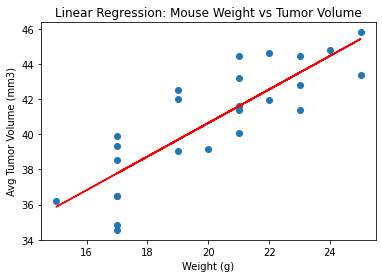

In [33]:
mt_slope, mt_int, mt_r, mt_p, mt_std_err = scs.linregress(weight,avg_tumor_volume)
mt_fit = mt_slope * weight + mt_int

plt.scatter(weight,avg_tumor_volume)
plt.plot(weight,mt_fit,"-", color='red')
plt.title('Linear Regression: Mouse Weight vs Tumor Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Avg Tumor Volume (mm3)')
plt.show()
plt.show()